In [1]:
import copy
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt
import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample

from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import helper
from synth.synth_architecture import SynthModular
from config import SynthConfig

from config import configure_experiment
from ai_synth_dataset import AiSynthDataset

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Setup experiment

exp_name = 'vis_test'
dataset_name = 'fm_toy_dataset'
device = 'cuda:1'
resample_op = Resample(orig_freq=16000, new_freq=50).to('cpu')

cfg, model_cfg, synth_cfg, dataset_cfg = configure_experiment(exp_name, dataset_name)

synth = SynthModular(synth_cfg=synth_cfg, sample_rate=cfg.sample_rate, device=device, num_sounds=1,
                     signal_duration_sec=cfg.signal_duration_sec, preset=synth_cfg.preset)

dataset = AiSynthDataset(dataset_cfg.train_parameters_file, dataset_cfg.train_audio_dir, device)



Deleting previous experiment...


In [3]:
dataset = AiSynthDataset(dataset_cfg.train_parameters_file, dataset_cfg.train_audio_dir, device)

target_sample = dataset[365]
target_signal, target_param_dict, signal_index = target_sample

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(0, 0): {'operation': 'lfo', 'parameters': {'freq': 17.548710944133386, 'waveform': 'sawtooth'}}, (1, 0): {'operation': 'None', 'parameters': 'None'}, (2, 0): {'operation': 'None', 'parameters': 'None'}, (3, 0): {'operation': 'None', 'parameters': 'None'}, (0, 1): {'operation': 'fm', 'parameters': {'freq_c': 622.253967444162, 'waveform': 'sawtooth', 'mod_index': 0.20019194710381588}}, (1, 1): {'operation': 'None', 'parameters': 'None'}, (2, 1): {'operation': 'None', 'parameters': 'None'}, (3, 1): {'operation': 'None', 'parameters': 'None'}, (0, 2): {'operation': 'None', 'parameters': 'None'}, (1, 2): {'operation': 'None', 'parameters': 'None'}, (2, 2): {'operation': 'None', 'parameters': 'None'}, (3, 2): {'operation': 'None', 'parameters': 'None'}, (0, 3): {'operation': 'None', 'parameters': 'None'}, (1, 3): {'operation': 'None', 'parameters': 'None'}, (2, 3): {'operation': 'None', 'parameters': 'None'}, (3, 3): {'operation': 'None', 'parameters': 'None'}, (0, 4): {'operation': 'None'

In [17]:
cfg.multi_spectral_loss_spec_type = 'BOTH'
loss_handler = helper.SpectralLoss(cfg=cfg,
                                   fft_sizes=(64, 128),#(64, 128, 256, 512, 1024, 2048),
                                   loss_type='L1',
                                   mag_weight=1,
                                   delta_time_weight=0,
                                   delta_freq_weight=0,
                                   cumsum_freq_weight=0,
                                   cumsum_time_weight=0,
                                   logmag_weight=0,
                                   normalize_by_size=True,
                                   device=device)

C:\ProgramData\Anaconda3\envs\ai_synth\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (33) may be set too low.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\ai_synth\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


In [18]:
loss_handler.spectrogram_ops

{'64_spectrogram': Spectrogram(),
 '64_mel': MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 ),
 '128_spectrogram': Spectrogram(),
 '128_mel': MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 )}

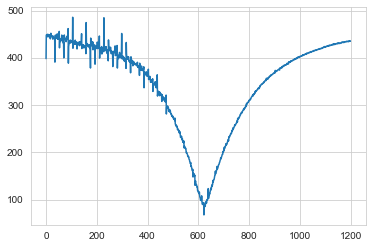

In [19]:
fm_freq_vals = np.linspace(0, 1200, 1200)

losses = []
for freq_val in fm_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0,1)]['parameters'].update({'freq_c': freq_val})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal()

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()

    loss_val = loss_handler.call(target_signal, signal, signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses.append(loss_val.detach().cpu().numpy())

plt.plot(losses)
plt.show()

In [ ]:
sim_target_params = {'freq_c'}

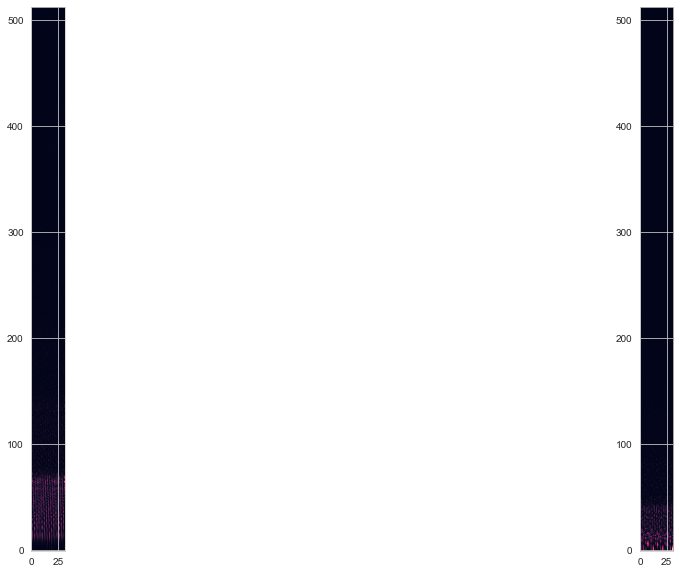

In [8]:
spec_op = Spectrogram(n_fft=1024)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

target_spec = spec_op(target_signal.cpu())

update_params = copy.deepcopy(target_param_dict)

update_params[(0,1)]['parameters'].update({'freq_c': 200})
synth.update_cells_from_dict(update_params)
signal, _ = synth.generate_signal()

pred_spec = spec_op(signal.cpu().detach())

ax[0].imshow(target_spec.squeeze(), origin='lower')
ax[1].imshow(pred_spec.squeeze(), origin='lower')